In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
words = open('/content/drive/MyDrive/names.txt','r').read().splitlines()

In [ ]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s, i in s2i.items()}

In [ ]:
# hyperparameters
BLOCK_SIZE = 3
EMBEDDING_SIZE = 10
NUM_NEURONS = 250
BATCH_SIZE = 56

In [ ]:
def generate_dataset(words):
  block_size = BLOCK_SIZE
  x, y = [], []

  # here the setup is like a rolling window. New context is being appended, old ones being removed, so the context moves/slides along
  for w in words:
    #print(w)
    context = [0] * block_size

    for ch in w + '.':
      ix = s2i[ch]
      x.append(context)
      y.append(ix)

      #print(''.join(i2s[i] for i in context), '---->', i2s[ix]) # first 3 characters ----> next character in data
      context = context[1:] + [ix] # crop and append

  x = torch.tensor(x)
  y = torch.tensor(y)
  return x, y

In [ ]:
def split_dataset(words):
  random.seed(42)
  random.shuffle(words)
  n1 = int(0.8*len(words))
  n2 = int(0.9*len(words))

  X_train, Y_train = generate_dataset(words[:n1])
  X_dev, Y_dev = generate_dataset(words[n1:n2])
  X_test, Y_test = generate_dataset(words[n2:])

  return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

In [ ]:
def initialize_parameters(x):
  x.shape[1]
  g = torch.Generator().manual_seed(2147483647)
  C = torch.randn((27,EMBEDDING_SIZE), generator=g)
  W1 = torch.randn((x.shape[1]*EMBEDDING_SIZE , NUM_NEURONS), generator=g)
  b1 = torch.randn((NUM_NEURONS), generator=g)
  W2 = torch.randn((NUM_NEURONS, 27), generator=g)
  b2 = torch.randn((27), generator=g)
  #W3 = torch.randn((81,27), generator=g)
  #b3 = torch.randn((27), generator=g)

  parameters = [C, W1, W2, b1, b2]
  ss = sum(p.nelement() for p in parameters)
  print(f"Number of parameters: {ss}")
  for p in parameters:
    p.requires_grad = True

  return parameters

In [ ]:
def evaluate_model(X, Y, param_list):
  # C  = params[0]
  # W1 = params[1]
  # W2 = params[2]
  # b1 = params[3]
  # b2 = params[4]

  emb = param_list[0][X]  # X[ix] to grab only mini-batch examples
  h1 = torch.tanh(emb.view(-1,emb.shape[1]*emb.shape[2]) @ param_list[1] + param_list[3])
  #h2 = torch.tanh(h1 @ param_list[2] + param_list[5])
  logits = h1 @ param_list[2] + param_list[4]
  loss = F.cross_entropy(logits, Y)
  print(f"Loss on dataset X: {loss.item()}")

In [ ]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = split_dataset(words)

In [ ]:
X, Y = generate_dataset(words)

In [ ]:
param_list = initialize_parameters(X_train)

Number of parameters: 14797


In [ ]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre
lrs.shape

torch.Size([1000])

In [ ]:
lr_decay_list = [0.1788, 0.15, 0.1, 0.05, 0.001]

In [ ]:
def train(X, Y, param_list, lr_decay_list, epoch):
  lri = []
  lossi = []
  stepi = []
  print(f"Num of Examples: {X_train.shape[0]}")
  j = 0
  #lr = 0.1788
  for i in range(250000):
    # C  = param_list[0]
    # W1 = param_list[1]
    # W2 = param_list[2]
    # W3 = param_list[3]
    # b1 = param_list[4]
    # b2 = param_list[5]
    # b3 = param_list[6]
    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (64,))

    #forward pass
    emb = param_list[0][X_train[ix]]  # X[ix] to grab only mini-batch examples
    h1 = torch.tanh(emb.view(-1,emb.shape[1]*emb.shape[2]) @ param_list[1] + param_list[3])
    #h2 = torch.tanh(h1 @ param_list[2] + param_list[5])
    logits = h1 @ param_list[2] + param_list[4]

    loss = F.cross_entropy(logits, Y_train[ix]) # Y[ix] mini batch
    #print(f"Loss on mini batche {i}: {loss.item()}")

    # backward pass
    for p in param_list:
      p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    if i%50000==0:
      lr = lr_decay_list[j]
      j+=1

    for p in param_list:
      p.data += -lr * p.grad

    #-------Track Stat---------
    stepi.append(i)
    #lri.append(lre[i])
    lossi.append(loss.item())

  print(f"Loss on mini batches: {loss.item()}")
  return loss , [stepi,lossi]

In [ ]:
loss , plot_value = train(X_train, Y_train, param_list, lr_decay_list, 250000)

Num of Examples: 182625
Loss on mini batches: 1.8717135190963745


In [ ]:
plot_value[1].index(min(plot_value[1])),min(plot_value[1]) #lr=.1788

(750, 3.6469175815582275)

In [ ]:
evaluate_model(X_train,Y_train,param_list)

Loss on dataset X: 2.0161032676696777


In [ ]:
evaluate_model(X_dev,Y_dev,param_list)

Loss on dataset X: 2.1098642349243164


In [ ]:
evaluate_model(X_test,Y_test,param_list)

Loss on dataset X: 2.113649845123291


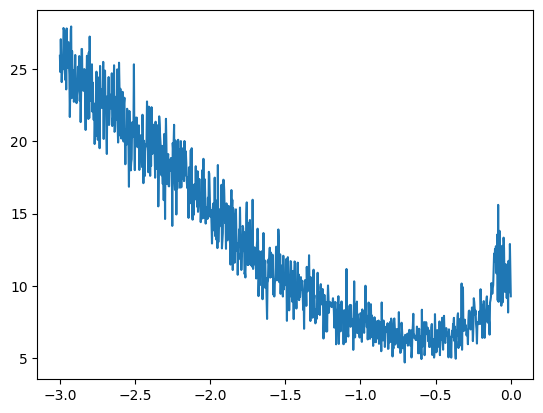

In [ ]:
plt.plot(lri,lossi)

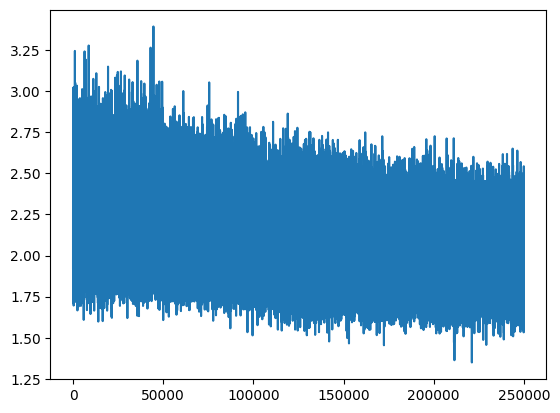

In [ ]:
plt.plot(plot_value[0], plot_value[1])

In [ ]:
# If our probabilities were uniform, then each character has an equal chance of being picked, i.e 1/27 probability. So it'd be



In [ ]:
# @title ###SAMPLING
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
  out = []
  context = [0] * BLOCK_SIZE
  while True:
    xxx = torch.tensor(context)
    emb_xxx = param_list[0][xxx]
    h_xxx = torch.tanh(emb_xxx.view(1,-1) @ param_list[1] + param_list[3])
    logits = h_xxx @ param_list[2] + param_list[4]
    probs = torch.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(i2s[i] for i in out))

junide.
jakarie.
pres.
azaine.
kai.
rito.
sabe.
ter.
kalania.
zamilena.


In [ ]:
# See below:
"""
| |
| |
| |
| |


Dim 0 sums in the direction of that. Move your hand in the direction of | and compress.

Dim 1 sums in this direction:
-----------
-----------
-----------

Moved your hands in the direction of --- and clap them together. That's how it sums.

Ask yourself -- in which way does that dim propagate? like is it
row
row
row
row,

or is it:
col col col col.

etc...
That's the way you sum.

Remember, broadcasting is import to take int oaccount too!!!!!
https://www.youtube.com/watch?v=PaCmpygFfXo 43:00
"""
##REMEMBERT KIDS: SUMMING BY THAT DIMENSION (e.g dim 0, the row dimension) means that row IS SUMMED!!!. So for a (27, 27), summing by dim 0 would become (1,27). The rows (downwards) are summed together!
